## PyTorch: Machine Learning

In [3]:
import torch
import torch.nn as nn
from torch.optim import SGD
import numpy as np
import matplotlib.pyplot as plt
import time

Let's consider a data set that consists of a independent vector $x_i$ and a dependant vector $y_i$.  
The goal of a neural network is to find a function that can make predictions:  
$$
\hat{y_i} = f(x_i; a)
$$  
Where $a$ is parameter vector.

We can define a *Loss* function $L(y, \hat{y})$, which is inversly proportional to the difference between $y_i$s and $\hat{y}$s. Example of a simple loss function:  
$$
L(y, \hat{y}) = \sum_i (y_i - \hat{y_i})^2
$$

#### Example:

In [44]:
x = torch.tensor([[6,2],[5,2],[1,3],[7,6]]).float()
y = torch.tensor([1,5,2,5]).float()

In [15]:
x.shape, x, y.shape, y

(torch.Size([4, 2]),
 tensor([[6., 2.],
         [5., 2.],
         [1., 3.],
         [7., 6.]]),
 torch.Size([4]),
 tensor([1., 5., 2., 5.]))

We want to predict $y$ using the $x$ tensor:  
We have $x_1 = (6,2), x_2 = (5,2), \dots$  
And $y_1 = 1, y_2 = 5, \dots$

Now let's define the parameter vector $a$, this can be as large as we want it to be.  
Let's multiply each vector element ($(6,2)$, etc.) by an $8\times{2}$ matrix (this is 16 parameter $a_i$).  
Now multiply each element in $x$ by a $1\times{8}$ matrix (this is 8 parameters $a_i$).

In [19]:
#The matrix is initially created with random values
#We create the matrix with no bias, i.e. no scalar value for the function
M1 = nn.Linear(2, 8, bias = False)
M1

Linear(in_features=2, out_features=8, bias=False)

In [22]:
#If we pass x, each of it's elements (2d vectors) are multiplied by M1
#Giving us a tensor formed by four 8d vectors
M1(x)

tensor([[-1.0400,  3.4515,  2.3830,  1.5895,  1.3507,  4.5750,  2.1904,  3.2824],
        [-0.7310,  2.7467,  1.9173,  1.5138,  1.3155,  3.9038,  2.0021,  2.8887],
        [ 0.9114, -0.4616, -0.1508,  1.7788,  1.7442,  1.4930,  1.7796,  1.7740],
        [ 0.2782,  2.6012,  2.0267,  3.9360,  3.6645,  6.3420,  4.5005,  5.5166]],
       grad_fn=<MmBackward0>)

In [23]:
#Our second matrix M2
M2 = nn.Linear(8, 1, bias = False)
M2

Linear(in_features=8, out_features=1, bias=False)

In [27]:
M2(M1(x))

tensor([[1.3737],
        [1.2747],
        [1.2688],
        [3.0324]], grad_fn=<MmBackward0>)

In [28]:
#Our result doesn't line up (dimension-wise) to the expected result y
M2(M1(x)).shape, y.shape

(torch.Size([4, 1]), torch.Size([4]))

In [31]:
#We can remove the extra dimension with the function:
M2(M1(x)).squeeze().shape, M2(M1(x)).squeeze()

(torch.Size([4]),
 tensor([1.3737, 1.2747, 1.2688, 3.0324], grad_fn=<SqueezeBackward0>))

We see that our result doesn't match the expected result $y_i$. This is because the parameters haven't been touched (or trained). This is were machine learning comes in to play, where we can train our network in order to optimize the values of M1 and M2 

In [46]:
#We create a subclass of nn.Module to store the parameters of a
#Later we can adjust these weights

class MyNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(2,8,bias=False)
        self.Matrix2 = nn.Linear(8,1,bias=False)
    def forward(self,x):
        x = self.Matrix1(x)
        x = self.Matrix2(x)
        return x.squeeze()

In [47]:
f = MyNeuralNet()

In [48]:
for par in f.parameters():
    print(par)

Parameter containing:
tensor([[-0.6957, -0.2445],
        [ 0.3150,  0.5439],
        [-0.1474, -0.4681],
        [-0.3217,  0.3290],
        [-0.1569, -0.4198],
        [-0.3657,  0.3634],
        [-0.1470,  0.4067],
        [ 0.6392, -0.3233]], requires_grad=True)
Parameter containing:
tensor([[ 0.0838, -0.0183,  0.0029,  0.1806,  0.2983, -0.0258, -0.0474, -0.3128]],
       requires_grad=True)


In [50]:
yhat = f(x)
y, yhat

(tensor([1., 5., 2., 5.]),
 tensor([-2.1679, -1.8150, -0.4284, -2.6214], grad_fn=<SqueezeBackward0>))

#### Adjusting $a$ so that $\hat{y}$ and $y$ are similar

In [51]:
#We'll use a builtin loss function of mean squared error
L = nn.MSELoss()
L(y, yhat)

tensor(30.1155, grad_fn=<MseLossBackward0>)

The main idea is to compute the gradient of $L$ in respect to $a$, this is:  
We have the loss function (which we want to minimize) $L = L(a)$, we want to find:  
$$
\frac{\partial L}{\partial a_i}
$$  
For each parameter $a_i$ we want to adjust it as follows:  
$$
a_i \rightarrow a_i - \ell\frac{\partial L}{\partial a_i}
$$  
Where $\ell$ is the learning rate (how fast is $a_i$ adjusted with every training batch. If $\ell$ is to large we will constantly be "overshooting" the local minimum we are looking for.

To do this we can use the SDG function (stochastic gradient descent)

In [53]:
#This function takes the parameters and learning rate
opt = SGD(f.parameters(), lr = 0.001)

In [54]:
#We can now adjust the parameters over and over
losses = []
for _ in range(50):
    opt.zero_grad() #flush previous gradient
    loss_value = L(f(x), y) #compute loss
    loss_value.backward() #compute gradient
    opt.step() #perform iteration using the gradient
    losses.append(loss_value.item())

Plot Loss function with different iterations

Text(0.5, 0, 'Epochs')

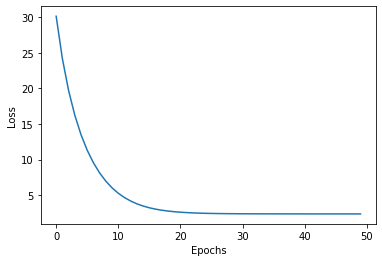

In [57]:
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Epochs")

In [58]:
f(x), y

(tensor([2.9119, 2.5870, 1.7690, 5.1622], grad_fn=<SqueezeBackward0>),
 tensor([1., 5., 2., 5.]))